In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, \
StratifiedKFold, cross_val_score, learning_curve, validation_curve, \
GridSearchCV
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, precision_score, \
recall_score, f1_score, make_scorer

In [2]:
df = pd.read_csv('datasets/r06/wdbc.data', header=None)
df.head(n=2)

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,842302,M,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902


In [3]:
X = df.values[:, 2:]
y = df.values[:, 1]
X = np.array(X, dtype='float64')
le = LabelEncoder()
y = le.fit_transform(y)
print(le.classes_)
le.transform(['M', 'B'])

['B' 'M']


array([1, 0], dtype=int64)

In [4]:
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.20,
                     stratify=y, random_state=1)

In [5]:
pipe_lr = make_pipeline(StandardScaler(),
             PCA(n_components=2),
             LogisticRegression(multi_class='ovr',
             solver='lbfgs', random_state=1))
pipe_lr.fit(X_train, y_train)
y_pred = pipe_lr.predict(X_test)
print('Accuracy on test set: %.3f' % (pipe_lr.score(X_test, y_test)) )

Accuracy on test set: 0.956


In [6]:
kfold = StratifiedKFold(n_splits=10,
                       random_state=1)
kfold = kfold.split(X_train, y_train)

scores = []
for k, (train, test) in enumerate(kfold):
    pipe_lr.fit(X_train[train], y_train[train])
    score = pipe_lr.score(X_train[test], y_train[test])
    scores.append(score)
    print('Fold: %d, Class distribution [%d, %d], Accuracy: %.3f' %
          (k, np.bincount(y_train[train])[0], np.bincount(y_train[train])[1], score))
    
print('\n Validation accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

Fold: 0, Class distribution [256, 153], Accuracy: 0.935
Fold: 1, Class distribution [256, 153], Accuracy: 0.935
Fold: 2, Class distribution [256, 153], Accuracy: 0.957
Fold: 3, Class distribution [256, 153], Accuracy: 0.957
Fold: 4, Class distribution [256, 153], Accuracy: 0.935
Fold: 5, Class distribution [257, 153], Accuracy: 0.956
Fold: 6, Class distribution [257, 153], Accuracy: 0.978
Fold: 7, Class distribution [257, 153], Accuracy: 0.933
Fold: 8, Class distribution [257, 153], Accuracy: 0.956
Fold: 9, Class distribution [257, 153], Accuracy: 0.956

 Validation accuracy: 0.950 +/- 0.014


In [7]:
scores = cross_val_score(estimator=pipe_lr,
                         X=X_train,
                         y=y_train,
                         cv=10)
print('10 fold cross-validation results: \n', scores)
print('\n Validation accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

10 fold cross-validation results: 
 [0.93478261 0.93478261 0.95652174 0.95652174 0.93478261 0.95555556
 0.97777778 0.93333333 0.95555556 0.95555556]

 Validation accuracy: 0.950 +/- 0.014


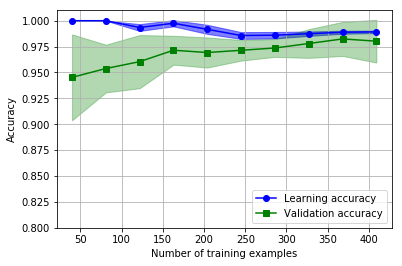

In [8]:
pipe_lr = make_pipeline(StandardScaler(),
                        LogisticRegression(penalty='l2', solver='lbfgs', max_iter=1000))
train_sizes, train_scores, test_scores =\
                learning_curve(estimator=pipe_lr,
                               X=X_train,
                               y=y_train,
                               train_sizes=np.linspace(0.1, 1.0, 10),
                               cv=10)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, color='blue', marker='o',
         label='Learning accuracy')
plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 color='blue', alpha=0.5)
plt.plot(train_sizes, test_mean, color='green', marker='s',
         label='Validation accuracy')
plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 color='green', alpha=0.3)
plt.grid()
plt.xlabel('Number of training examples')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1.01])
plt.legend(loc='lower right')
plt.show()

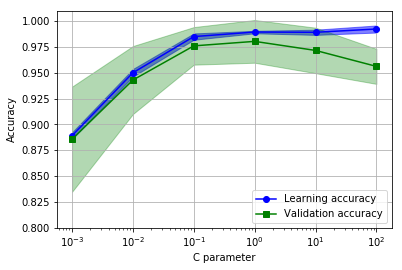

In [9]:
param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
train_scores, test_scores = validation_curve(
                estimator=pipe_lr, X=X_train, y=y_train,
                param_name='logisticregression__C',
                param_range=param_range, cv=10)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(param_range, train_mean, color='blue', marker='o',
         label='Learning accuracy')
plt.fill_between(param_range,
                 train_mean + train_std,
                 train_mean - train_std,
                 color='blue', alpha=0.5)
plt.plot(param_range, test_mean, color='green', marker='s',
         label='Validation accuracy')
plt.fill_between(param_range,
                 test_mean + test_std,
                 test_mean - test_std,
                 color='green', alpha=0.3)
plt.grid()
plt.xlabel('C parameter')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1.01])
plt.xscale('log')
plt.legend(loc='lower right')
plt.show()

In [10]:
pipe_svm = make_pipeline(StandardScaler(), SVC())
param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
param_grid = [{'svc__C': param_range,
               'svc__kernel': ['linear']},
              {'svc__C': param_range,
               'svc__gamma': param_range,
               'svc__kernel': ['rbf']}]
gs = GridSearchCV(estimator=pipe_svm, param_grid=param_grid,
                  scoring='accuracy', cv=10, n_jobs=-1)
gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.9846153846153847
{'svc__C': 100.0, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}


In [11]:
clf = gs.best_estimator_
clf.fit(X_train, y_train)
print('Test accuracy: %.3f' % clf.score(X_test, y_test))

Test accuracy: 0.974


In [19]:
gs = GridSearchCV(estimator=pipe_svm, param_grid=param_grid,
                  scoring='accuracy', cv=2)
scores = cross_val_score(estimator=gs, X=X_train, y=y_train, scoring='accuracy', cv=5)
print('Cross validation accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

Cross validation accuracy: 0.974 +/- 0.015


In [38]:
gs = GridSearchCV(estimator=DecisionTreeClassifier(),
                  param_grid=[
                      {'max_depth': [1, 2, 3, 4, 5, 6, 7, None]}],
                       scoring='accuracy', cv=2)
scores = cross_val_score(estimator=gs, X=X_train, y=y_train,
                         scoring='accuracy', cv=5)
print('Cross validation accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

Cross validation accuracy: 0.930 +/- 0.027


In [42]:
pipe_svm.fit(X_train, y_train)
y_pred = pipe_svm.predict(X_test)
conf_mat = confusion_matrix(y_test, y_pred)
print(conf_mat)

[[71  1]
 [ 2 40]]


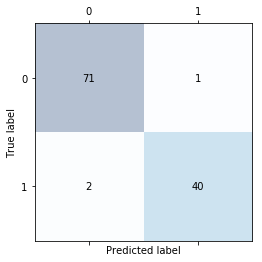

In [67]:
fig, ax = plt.subplots()
ax.matshow(conf_mat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_mat.shape[0]):
    for j in range(conf_mat.shape[1]):
        ax.text(x=j, y=i, s=conf_mat[i, j],
                va='center', ha='center')
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')
plt.show()

In [74]:
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print('Precision: %.3f' % prec)
print('Recall: %.3f' % rec)
print('F1 score: %.3f' % f1)

Precision: 0.976
Recall: 0.952
F1 score: 0.964


In [79]:
scorer = make_scorer(f1_score, pos_label=0)
gs = GridSearchCV(estimator=pipe_svm,
                  param_grid=param_grid,
                  scoring=scorer,
                  cv=10)
gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.9880219137963148
{'svc__C': 100.0, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}


In [55]:
rec

0.9523809523809523